# Using Persistent Cup Products for Dissonance Detection

### MSRI-UP 2023

Authors: Kimberly Herrera, Martin Martinez, Austin MBaye 

Date: 07/21/2023

In [1]:
#import important libraries 
import time
import wave
import tadasets
import numpy as np
from ripser import ripser
from scipy.io import wavfile
from persim import plot_diagrams
from IPython.display import Audio
from matplotlib.pyplot import show
from itertools import combinations
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.fft import fft, fftfreq, fftshift
from sklearn.metrics import pairwise_distances
from IPython.display import display, Audio, FileLink
%matplotlib inline

### Goal
We want to take a time series $f$, and detect any quasiperiodic behavior. To do this, we present the following algorithm that takes the two highest points in $H_1$ in the persistence diagram of the Rips filtration on the sliding window point cloud of $f$, takes the cup product between them, and plots the product on the diagram. Should this new point be highly persistent, then the time series is quasiperiodic. The motivation behind this is that quasiperiodic functions produce point clouds that are dense in tori, so we want their persistence diagram to "match" that of a torus with the addition of the cup product to confirm that the function has the correct structure.

We will apply this algorithm on music to detect dissonance. This will work because when you have dissonance, the frequencies of the music notes are linearly independent of each other so you get a quasiperiodic signal.

#### For the next cell, put your volume up!

In [2]:
wav_file = '0 noise.wav' #replace with the path on your machine

# Display the audio player
Audio(wav_file)

Here, we load in a sample of the noise file and convert it to a time series.

In [3]:
file_path = '0 noise.wav' #replace with the path on your machine
sample_rate, audio_data = wavfile.read(file_path)

# Define start and end times (in seconds)
start_time = 0.0
end_time = 0.1

# Convert the time values to corresponding sample indices
start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

# Trim the audio data array
audio_data = audio_data[start_index:end_index]

# Normalize audio
audio_data = audio_data / np.max(audio_data)

# Convert stereo to mono
if audio_data.ndim > 1:
    audio_data = audio_data.mean(axis=1)
duration = (len(audio_data) / sample_rate) * 1000
real_time = np.linspace(0, duration, len(audio_data))

/var/folders/40/zmgqdh5124d3j5h3bdpln8m80000gn/T/ipykernel_24970/318060813.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(file_path)


#### What does this time series look like?

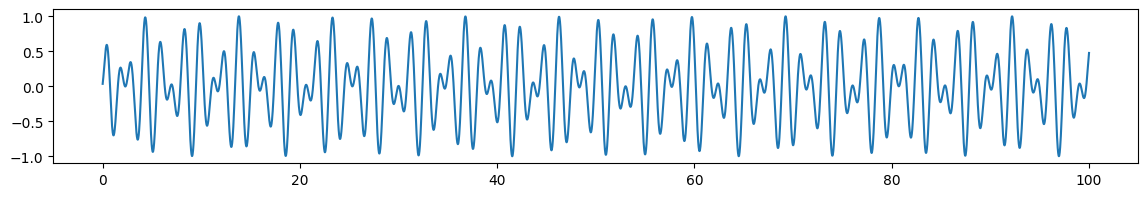

In [4]:
plt.figure(figsize = (14,2))
plt.plot(real_time, audio_data);

### Step 1: Function &#8594; Point Cloud
When applying sliding windows to a time series, a window of fixed size slides along the data, and the points within the window are collected to form a point cloud. The embedding dimension ($d$) refers to the number of dimensions/features used to represent each point in the sliding window. The time delay ($\tau$) specifies the time lag between the starting positions of adjacent windows. The delay can be thought of as the step size used to slide the window along the data. We want to optimize the values of $d$ and $\tau$ before applying sliding windows.

##### Finding $d$ : 
We want to compute a Fast Fourier Transform (FFT). This takes a series given by amplitude vs. time and returns it as amplitude vs. frequency, that way we can determine which frequency peaks in the time series are the strongest. The number of prominent peaks is what determines $d$.

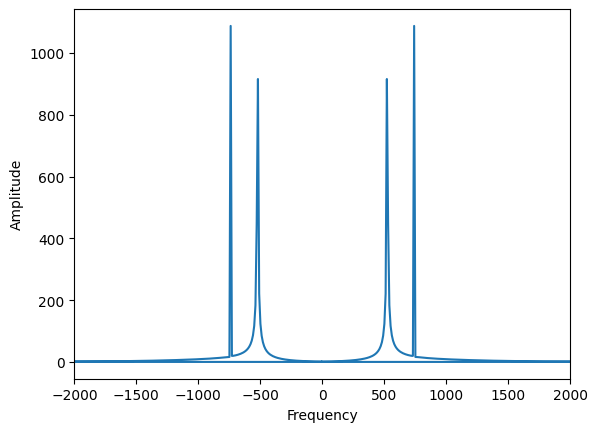

In [5]:
# Perform FFT
fft_result = np.fft.fft(audio_data)

# Compute the frequencies corresponding to the FFT result
sample_rate = 1 / (real_time[1] - real_time[0])  # Sampling rate
frequencies = np.fft.fftfreq(len(audio_data), 1 / sample_rate)

plt.plot(frequencies * 1000, np.abs(fft_result))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim([-2000, 2000])
plt.show()

How many peaks do you see? 

In [6]:
d = 4 #put the number of peaks here

Now, we take the result of our FFT and sort it so that the frequencies with the strongest peaks are listed first.

In [7]:
unsorted_fft = []
for i in range(len(frequencies)):
    if frequencies[i] * 1000 >= 0:
        pair = (frequencies[i] * 1000, np.abs(fft_result)[i])
        unsorted_fft.append(pair)
fft_array = sorted(unsorted_fft, key=lambda x: x[1], reverse=True) #find strongest frequency

##### Finding $\tau$ :
We want a $\tau$ that miminizes the following equation:
 
$\displaystyle \Gamma(x) = \sum_{k \neq k'} \left\vert 1 + e^{ix \langle k - k', \omega \rangle} + \ldots + e^{ix \langle k - k', \omega \rangle d} \right\vert^2$.

This sums over every pair of distinct peaks, k and k' are the frequency values of the two distinct prominent peaks. 

First, we return the frequency locations of the $d$ strongest peaks.

In [8]:
prominent_peaks = []

for i in range(d):
    prominent_peaks.append(fft_array[i][0])

prominent_peaks

[739.8321995464853, 519.8820861678005, 529.8798185941043, 509.8843537414967]

Then, we define functions that will compute the formula for $\Gamma$ from above, depending on the value of $d$.

In [9]:
def tau_lowD(tau):
    tau_sum = 0
    for i in range(len(prominent_peaks)):
        for j in range(i):
            re_sum = 0
            im_sum = 1
            for k in range(d + 1):
                re_sum += np.cos((prominent_peaks[i] - prominent_peaks[j]) * tau * k)
                im_sum += np.sin((prominent_peaks[i] - prominent_peaks[j]) * tau * k)
            tau_sum += (re_sum ** 2) + (im_sum ** 2)
    return tau_sum

def tau_highD(tau_vals):
    sum_array = np.array([])
    for tau in tau_vals:
        tau_sum = 0
        for diff in difference_array:
            input_array = np.array([])
            input_array = np.append(input_array, diff * tau * d_array)
            re_norm = np.sum(np.cos(input_array))
            im_norm = np.sum(np.sin(input_array))
            tau_sum += re_norm ** 2 + im_norm ** 2
        sum_array = np.append(sum_array, tau_sum)
    return sum_array

Finally, we use these formulas to compute the minimal $\tau$ value.

In [10]:
tau_vals = np.linspace(0, 1, 30000)

if d < 9:
    min_sum = np.inf
    best_tau = None
    for tau in tau_vals:
        temp_sum = tau_lowD(tau)
        if temp_sum < min_sum:
            min_sum = temp_sum
            best_tau = tau
else:
    d_array = np.array([])
    for i in range(d + 1):
        d_array = np.append(d_array, i)
    difference_array = np.array([])
    for i in range(len(prominent_peaks)):
        for j in range(i):
            difference_array = np.append(difference_array, prominent_peaks[i] - prominent_peaks[j])
    best_tau = tau_vals[np.argmin(tau_highD(tau_vals))]

#### Now that we have all the optimal parameters, we can compute the sliding window point cloud:

In [11]:
def SW_cloud(f, tau, d, n_data):
    # Inputs:
    # f : time series -- array of size (2,N) (x and y values) or (1,N) (only y values)
    #For simplicity, we will assume that f, our time series is a nested list of two lists, each with x1, x2, ... xn and y1, y2,... and yn respectively.
    # tau: delay -- positive real number
    # d : gives embedding dimension d+1 -- integer
    # n_data : desired number of points in SW point cloud -- intenger
    #
    # Output:
    # SW : sliding window point cloud -- array of size (n_data,  d+1)

    #Step 1: turn f into a cubic spline
        x_vals = f[0]
        y_vals = f[1]
        cs = CubicSpline(x_vals, y_vals)


    #Step 2: create the t values where to evaluate SW_f
        t_vals = np.linspace(np.min(x_vals),np.max(x_vals)-(d*tau),n_data)
 

    #Step 3: evaluate the sliding window point cloud
        SW=[]
        for t in t_vals:
            SW_f_t=cs(t + np.arange(0,d+1)*tau)
            SW.append(SW_f_t)
        SW=np.array(SW)

        return SW

In [12]:
f = np.array([real_time, audio_data])
d = d
tau = best_tau
n_data = 10000
SW_f = SW_cloud(f, tau, d, n_data)

### Step 2: Point Cloud &#8594; Persistence Diagram via Ripser

Now that we have a point cloud, we want to compute a persistence diagram. The Ripser library we imported at the start does this for us, but let's go over what it does! 

First we need to compute a Rips filtration on the point cloud:
1. Compute the pairwise distance between all points in the cloud.
2. Pick a distance threshold $\alpha$ and connects points that are within $\alpha$ of each other. This creates new simplices for our simplicial complex.

 A simplicial complex K, is a set of sets such that (1) if $\sigma \in K$, then $0 < \#(\sigma) < \infty$ and (2) if $\sigma \in K$, and $\emptyset \ne \tau \subset \sigma$, then $\tau \in K$.
 
We continue increasing $\alpha$ until all points in our cloud are connected. As $\alpha$ increases, simplices of higher dimension are created such as triangles and tetrahedra. Once everything is connected, we're left with a simplicial complex!

Ripser then takes the simplicial complex and computes the barcode, which consists of intervals representing a topological feature in our data (connected component, hole, etc). The intervals indicate the birth and death of the features as the filtration progresses. The length of an interval represents the feature's persistence. Ripser first constructs the total boundary matrix from the simplicial complex and then reduces it to extract the barcode.

This is then visualized as:

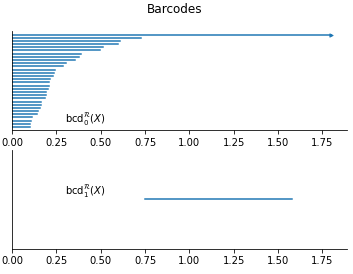

or as a persistence diagram:

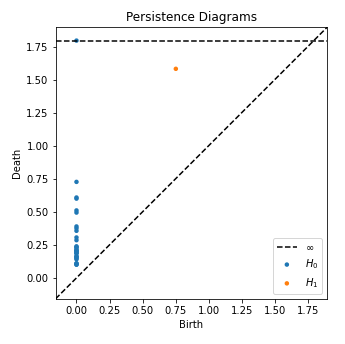

#### Now lets do this for our time series!

In [22]:
x = SW_f
n_landmarks = 115
result = ripser(x, coeff=2, n_perm = n_landmarks, maxdim = 3, do_cocycles=True)
#wanted to get 3rd homology so change max dim to 3
diagrams = result['dgms'] #get the persistence diagrams
dgm1 = diagrams[1] #persistence diagram for H^1
dgm2 = diagrams[2] #persistence diagram for H^2
dgm3 = diagrams[3] #persistence diagram for H^3
D = result['dperm2all'] #distance matrix

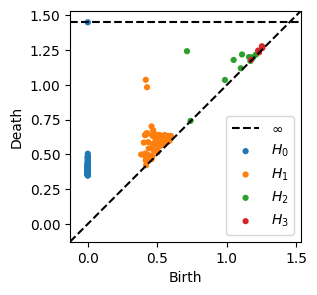

In [23]:
plt.figure(figsize = (12,3)) 
plt.subplot(1,3,1)
plot_diagrams(diagrams)
x_left, x_right = plt.xlim()
y_left, y_right = plt.ylim()

No we want to extract all of the cocycles from the persistence diagram. Cocycles are defined:

$C^n(K; \mathbb{F}) = \{\varphi:K^{(n)} \rightarrow \mathbb{F} \;\; \textit{s.t.} \;\;\#(supp(\varphi)) < \infty\}$,  where $K is a simplicial complex.

These are in the kernel of $\delta^{n+1}$ but not in the image of $\delta^n$, where 

$\delta^n(\varphi)(\sigma) = \displaystyle\sum_{n=0}^{n+1}(-1)^j\varphi(\sigma - \{x_j\})$, 
for $\varphi \in C^n(K;\mathbb{F})$ and $\sigma \in K$.

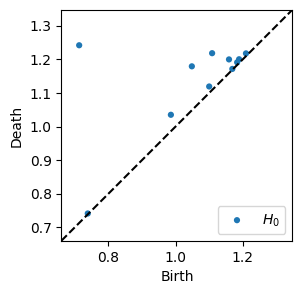

In [24]:
plt.figure(figsize = (12,3)) 
plt.subplot(1,3,1)
plot_diagrams(dgm2)
x_left, x_right = plt.xlim()
y_left, y_right = plt.ylim()
#not sure why the label says H_0 but this is the diagram for just H_2

In [25]:
cocycles = result['cocycles'] #all of the cocycles

### Step 3: Finding $\varphi$ and $\psi$

We now have a bunch of cocycles but we want the 2 most persistent ones. So we give our points in $H_1$ a persistence score:
$$\{b-a: (a, b) \in dgm_1\}$$ take the two points with the largest scores and find the cocycles that represent them.

In [26]:
#Representative cocycle phi
idx1 = np.argmax(dgm1[:, 1] - dgm1[:, 0]) #max persistence score
cocycle1 = cocycles[1][idx1] #get the cocycle with that score

In [27]:
#Representative cocycle psi
sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0]) 
idx2 = sorted_indices[-2] #second max persistent score
cocycle2 = cocycles[1][idx2] #get the cocycle with that score

Now we need to restrict $\varphi$ (the more persistent one) to the simplices for which $\psi$ persists!

In [28]:
#Restrict cocycle1
New_cocycle1=[]
edges=[]
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i:i-1, :2], cocycle1[i:i+1, :2], cocycle2[j:j+1, :2]):  
                New_cocycle1.append(cocycle2[j:j+1])
        New_cocycle1.append(cocycle2[i:i+1])        
rcocycle1=np.vstack(New_cocycle1)
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i-1:i, :2], cocycle2[j:j+1, :2]):
                edges.append(cocycle2[j:j+1])        
edges=np.vstack(edges)
window_size = d * best_tau * 0.9
for i in range(len(rcocycle1)):
    found_match = False
    for j in range(len(edges)):
        if np.array_equal(rcocycle1[i, :2], edges[j, :2]):
            found_match = True
            break
    if not found_match:
        rcocycle1[i, -1] = 0

We also want the representative cocycles for the triangles in our simplicial complex, this is so that we can compute a cup product.

In [37]:
# Finding the representative cocycles for triangles
representative_cocycles = []
for i in range(len(dgm1)):
    birth, death = dgm1[i]
    if birth != death:  # ignore points on the diagonal
        cocycle = cocycles[1][i]
        representative_cocycles.append(cocycle)
triangles = []
for cocycle in representative_cocycles:
    edge_indices = cocycle[:, :2].astype(int)
    triangle_vertices = set()
    for i, j in edge_indices:
        triangle_vertices.add(i)
        triangle_vertices.add(j)
    triangle_combinations = combinations(triangle_vertices, 3)
    for combination in triangle_combinations:
        triangles.append(list(combination))
t=np.vstack(triangles)

At some point we will want the tetrahedra as well.

In [38]:
# Finding the representative cocycles for tetrahedra
representative_cocycles_tet = []
for i in range(len(dgm2)):
    birth, death = dgm2[i]
    if birth != death:  # ignore points on the diagonal
        cocycle = cocycles[1][i]
        representative_cocycles_tet.append(cocycle)
tetrahedra = []
triangles = []
for cocycle in representative_cocycles_tet:
    edge_indices = cocycle[:, :2 :].astype(int)
    triangle_vertices = set()
    tetrahedra_vertices = set()
    for i, j in edge_indices:
        triangle_vertices.add(i)
        triangle_vertices.add(j)
    triangle_combinations = combinations(triangle_vertices, 3)
    for combination in triangle_combinations:
        triangles.append(list(combination))
    tet_combinations = combinations(tetrahedra_vertices, 4) 
    for combination in tet_combinations:
        tetrahedra.append(list(combination))
t=np.vstack(tetrahedra)

ValueError: need at least one array to concatenate

### Step 4: Taking the Cup Product

A cup product is a binary operation of cocycles defined by
$$\varphi \cup \psi(\{x_0, ..., x_{n+m}\}) = \varphi(\{x_0, \ldots, x_n\} \cdot \psi(\{x_n , \ldots, x_m\}).$$

Since we now have our restricted cocycle $\varphi|_\alpha$ and our cocycle $\psi$, we can take the cup product by computing $\varphi|_\alpha(\{x, y\}) \cdot \psi(\{y, z\})$ for every triangle $\{x, y, z\}$ in our filtration at $\alpha$.


In [ ]:
def cupProduct(phi, psi, triangleList):
    '''Computes the cup product given two cocycles and a list of triangles'''
    cupProduct = []
    for i in range(len(triangleList)):
        phiVal = 0
        psiVal = 0
        for j in range(len(phi)):
            if phi[j][0] == triangleList[i][0] and phi[j][1] == triangleList[i][1]:
                phiVal = phi[j][2]
                break;
        for k in range(len(psi)):
            if psi[k][0] == triangleList[i][1] and psi[k][1] == triangleList[i][2]:
                psiVal = psi[k][2]
                break;
        cupProduct.append(phiVal * psiVal)
    cupProduct = np.array(cupProduct).T
    return cupProduct

In [ ]:
# This cell might take a minute to run, please have patience!

cup=cupProduct(rcocycle1,cocycle2, t) # Computes the cup Product
cup=np.vstack(cup)

Now we have our cup product! To plot it on a persistence diagram, however, we need both a birth and death. For the birth, we set it to be the minimum of the births of $\varphi|_\alpha$ and $\psi$. The death, however, requires more work.

We need to find the row that makes the following equation not have a solution:

$$ \delta^1 \cdot x = \varphi |_\alpha \smile \psi$$

This will tell us for which triangle the cup product becomes part of the 1-coboundary (and dies). We have the right side of the equation, so we now need to compute $\delta^1$.

### Step 5: Computing the Coboundary Matrix $\delta^1$

First we need to know what are simplices are. We already have the triangles, so we need our vertices and edges.

In [ ]:
edges = []
vertices=[]
representative_cocycles = []
for i in range(len(dgm1)):
    birth, death = dgm1[i]
    if birth != death:  
        cocycle = cocycles[1][i]
        representative_cocycles.append(cocycle)
for cocycle in representative_cocycles: # Extracting every edge as an array of vertices
    edge_indices = cocycle[:, :2].astype(int)
    for i, j in edge_indices:
        edge = [i, j]
        edges.append(edge)
for cocycle in representative_cocycles: #Extracting every vertex
    vertex_indices = cocycle[:, :1].astype(int)
    for i in vertex_indices:
        vertices.append(i[0])
vertices = list(set(vertices)) # Remove duplicate vertices by converting the list to a set and then back to a list

Now we can compute the total boundary matrix.

In [ ]:
# This cell might also take a moment to run!

ne = len(edges)
nt = len(triangles)
nv = len(vertices)
num_rows= ne+nt+nv
num_cols=ne+nt+nv
boundary_matrix=np.zeros((num_rows, num_cols), dtype=int)
for i,edge in enumerate(edges):
    a,b=edge #a and b are the two verticies that make up the edge
    for j,vertex in enumerate(vertices):
        c=vertex # c is a vertex
        if b == c:
            boundary_matrix[nv+i,j]=1
        if a == c:
            boundary_matrix[nv+i,j]=-1
for i, triangle in enumerate(triangles):
    e,f,g=triangle #e,f,g are verticies in the triangle
    for j,edge in enumerate(edges):
        h,k=edge 
        if (h,k) == (e,f):
            boundary_matrix[(ne+nv)+i,nv+j]=1
        if (h,k) == (f,g):
            boundary_matrix[(ne+nv)+i,nv+j]=1
        if (h,k) == (e,g):
            boundary_matrix[(ne+nv)+i,nv+j]=-1
boundary_matrix=boundary_matrix.T

We then take restrict the matrix and take the antitranspose $D^\perp$ so that we can get $\delta^1$.

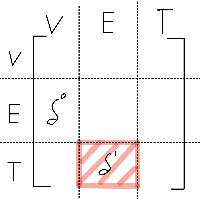

In [ ]:
#Convert Boundary Matrix into Coboundary
restricted_matrix = boundary_matrix[nv:nv + ne, nv + ne:len(boundary_matrix)]
coboundary_matrix = np.flip(restricted_matrix).T

### Step 5: Finding the Triangle

Now that we have both sides to our equation, we want to figure out which simplex makes the equation no longer have a solution, as that will tell us the precise moment when $\varphi|_\alpha \smile \psi$ is no longer a part of the 1-coboundary. To do this, we use a bisection method. First, we need a way to check if a solution exists, which we define below. The function only needs as input the matrix $\delta^1$ and the vector $\varphi|_\alpha \smile \psi$, and it returns 0 or 1 depending on if the matrix equation has a solution.

In [ ]:
def check_solution(A, b):
    """Calculates the rank of the augmented matrix [A | b]"""
    augmented_matrix = np.column_stack((A, b))
    rank_A = np.linalg.matrix_rank(A)
    rank_augmented = np.linalg.matrix_rank(augmented_matrix)
    num_columns = A.shape[1]
    num_rows = A.shape[0]
    if rank_A == rank_augmented:
        if rank_A == num_columns:
            return 1
        elif rank_A < num_columns:
            return 1
    else:
        if rank_A < rank_augmented:
            return 0
    return "Unable to determine the solution status."

Once we have defined this function, we can implement this bisection method. First, we start by restricting the matrix to its bottom half. Then, we check if that restricted equation has a solution. If it does, then that means that we need to satisfy too few equations for too many variables, so we increase our restriction by halfway. If the restricted equation does not have a solution, we ask another question: would the equation have had a solution if we were to restrict it by one more row? If so, then we've found the row were looking for! If not, then we have too many equations to satisfy for too few variables, so we decrease our restriction by halfway.

In [ ]:
def row_detect(A, b):
    """Finds the first row for which [A | b] has no solution"""
    i_max = len(A) + 1
    i_min = 1
    i = len(A) // 2
    running = True
    while running:
        sol = check_solution(A[-i:], b[-i:])
        if sol == 0:
            if check_solution(A[-(i - 1):], b[-(i - 1):]) == 1:
                row = len(A) - i
                running = False
                break;
            else:
                if i < i_max:
                    i_max = i
                    i = (i_max + i_min) // 2
        if sol == 1:
            if i > i_min:
                i_min = i
                i = (i_max + i_min) // 2
            if i == len(A):
                row = 0
                running = False
                break;
    return row

With these functions we can find the first row for which our matrix has no solution.

In [ ]:
detect = row_detect(coboundary_matrix, cup)

Now that we have a row, we need the triangle corresponding to that row.

In [ ]:
def rowTriangle(r):
    value=len(triangles)-r
    return triangles[value]
    
tri=rowTriangle(detect)

 ### Step 6: Finding the $\alpha$ that introduces the triangle

We need to find the smallest $\alpha$ where triangle becomes part of $R_{\alpha}$. We do this by iterating over increasing values of $\alpha$ until the triangle is born in our simplicial complex. This will give us the death of the cup product.

In [ ]:
sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
idx = sorted_indices[-2]
h = max(dgm1[idx, 0], dgm1[idx, 0])
while h < birth:
    new_run = ripser(x, coeff=2, n_perm = n_landmarks, thresh = h, do_cocycles = True)
    new_diagrams = new_run['dgms']
    new_cocycles = new_run['cocycles']
    D = new_run['dperm2all']
    new_dgm = new_diagrams[1]
    new_representative_cocycles = []
    for i in range(len(new_dgm)):
        new_coycle = new_cocycles[1][i]
        new_representative_cocycles.append(new_coycle)
    new_triangles = []
    for new_coycle in new_representative_cocycles:
        edge_indices = new_coycle[:, :2].astype(int)
        new_triangle_vertices = set()
        for i, j in edge_indices:
            new_triangle_vertices.add(i)
            new_triangle_vertices.add(j)
        new_triangle_combinations = combinations(new_triangle_vertices, 3)
        for combination in new_triangle_combinations:
            new_triangles.append(list(combination))
    if len(new_triangles) > 0:
        new_t=np.vstack(new_triangles)
        for k in range(len(new_t)):
            if new_t[k][0] == tri[0] and new_t[k][1] == tri[1] and new_t[k][2] == tri[2]:
                death=h #Gives the Cohomological death
                h = 1000000
                break;
    h += 0.1

### Step 7: Plot the Cup Product

Now that we have both the birth and death of the cup product, we can plot it on the persistence diagram.

In [ ]:
#Part 4: Plot the persistence diagram with the new point
birth=dgm1[idx2,1] #death of psi but birth of H2 point 
plot_diagrams(diagrams, show = False)
plt.gca().add_patch(plt.Circle((death, birth), 0.05, color='r', fill=False))
plt.scatter(death,birth, color='g')
plt.title("Peristence Diagram")
plt.show()

### Step 8: Giving the Product a Quasiperiodicity Score

We want our cup product to be a new highly persistent feature if the time series is quasiperiodic, but the word "highly" introduces subjectivity. We define a score that determines how persistent the product is in relation to the diameter of the point cloud, allowing us to determine if the time series is quasiperiodic or not.

In [ ]:
def point_cloud_diameter(points):
    # Calculate pairwise distances between points
    distances = pairwise_distances(points)

    # Find the maximum distance
    max_distance = np.max(distances)
    
    # Scale distance
    return max_distance * window_size

In [ ]:
QPDS = ((birth - death) * 10) / point_cloud_diameter(SW_f)
print("Quasiperiodicity Score: " + str(QPDS * 100) + "%")

# Solidifying the Algorithm 


We ran our algorithm with a tritone time series that was quasiperiodic. We decided to add noise to the tritone audio to see how it would affect quasiperiodicity detection by our algorithm. We can try 10% and 20% noise.

In [ ]:
wav_file = 'C:/Users/kimbe/Downloads/10 noise.wav' #replace with the path on your machine

# Display the audio player
Audio(wav_file)

In [ ]:
wav_file = 'C:/Users/kimbe/Downloads/20 noise.wav' #replace with the path on your machine

# Display the audio player
Audio(wav_file)

In [ ]:
wav_file = 'C:/Users/kimbe/Downloads/30 noise.wav' #replace with the path on your machine

# Display the audio player
Audio(wav_file)

We can repeat everything in the notebook using the proper wav file. More noise can be tested to see how much can be added until quasiperiodicity is not detected. In our experience, we have gotten it to work with up to 30% noise. Please note that you will need to increase the number of landmarks, and not every computer can handle it.

## Looking Foward

Recall that the cohomological birth of our cup product was defined as the minimum of $\varphi|_\alpha$ and $\psi$. However, if we have the following triangulation and simplicial complex, we suspect that the cup product could be born before the birth we defined.